In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score
from peft import get_peft_model, LoraConfig, TaskType

/Users/kevinhsu/Downloads/AIT 526/Skynet/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_train = pd.read_csv("data/train.csv", encoding='ISO-8859-1')
df_train.dropna(subset=['text', 'sentiment'], inplace=True)
df_test = pd.read_csv("data/test.csv", encoding='ISO-8859-1')
df_test.dropna(subset=['text', 'sentiment'], inplace=True)

# Ensure text data is a list of strings and drop missing values
df_train['text'] = df_train['text'].astype(str)
df_test['text'] = df_test['text'].astype(str)

df_train = df_train.rename(columns={'sentiment': 'label'})
df_test = df_test.rename(columns={'sentiment': 'label'})

df_train['label'] = df_train['label'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)
df_test['label'] = df_test['label'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)


df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)

In [3]:
model_name = 'google-bert/bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [22]:
# Convert DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train[['text', 'label']])
test_dataset = Dataset.from_pandas(df_test[['text', 'label']])

# Adding short max length to lower training time
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 3534/3534 [00:00<00:00, 34046.61 examples/s]


In [34]:
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [50]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model = model.to(device)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "value"],  # BERT uses query, key, value in attention
    lora_dropout=0.1,
    bias="all",
    task_type=TaskType.SEQ_CLS
)

training_args = TrainingArguments(
    output_dir="./results/" + model_name,
    learning_rate=2e-3,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    gradient_accumulation_steps=1,
    #gradient_checkpointing=True,
    num_train_epochs=30,
    dataloader_num_workers=5,
    #logging_steps=100,
    weight_decay=0.01,
)

model = get_peft_model(model, lora_config)
model = model.to(device)

for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# Define a compute metrics function
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    accuracy = accuracy_score(p.label_ids, preds)
    return {'accuracy': accuracy}

In [52]:
from transformers import TrainerCallback

class LossAccuracyLogger(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_accuracy = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_loss.append((state.epoch, logs["loss"]))
            if "eval_accuracy" in logs:
                self.eval_accuracy.append((state.epoch, logs["eval_accuracy"]))


In [53]:
logger_callback = LossAccuracyLogger()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[logger_callback]
)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


資料集中最長的 Token 長度是: 110


/Users/kevinhsu/Downloads/AIT 526/Skynet/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6587}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kevinhsu/Downloads/AIT 526/Skynet/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kevinhsu/Downloads/AIT 526/Skynet/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kevinhsu/Downloads/AIT 526/Skynet/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kevinhsu/Downloads/AIT 52

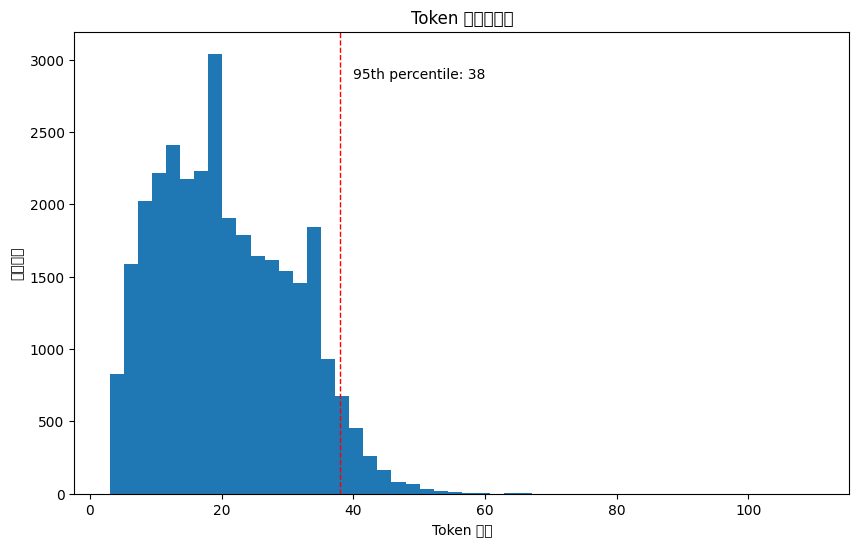

資料集中 95% 的文本 Token 長度小於或等於: 38


In [48]:
# --- 在 Cell 2 和 Cell 3 執行後，加入這個新的 Cell ---

# 計算訓練集中每個文本的 Token 長度
train_token_lengths = [len(tokenizer.encode(text)) for text in df_train['text']]
# 計算測試集中每個文本的 Token 長度
test_token_lengths = [len(tokenizer.encode(text)) for text in df_test['text']]

# 合併所有長度
all_token_lengths = train_token_lengths + test_token_lengths

# 找出最長的 Token 長度
max_len = max(all_token_lengths)

print(f"資料集中最長的 Token 長度是: {max_len}")

# (選用) 繪製長度分佈圖，幫助決定 max_length
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.hist(all_token_lengths, bins=50) # bins 可以調整，觀察更細緻的分佈
plt.title('Token 長度分佈圖')
plt.xlabel('Token 長度')
plt.ylabel('文本數量')
# 可以在圖上標示一個常用的百分位數，例如 95% 或 99%
percentile_95 = np.percentile(all_token_lengths, 95)
plt.axvline(percentile_95, color='red', linestyle='dashed', linewidth=1)
plt.text(percentile_95 * 1.05, plt.ylim()[1] * 0.9, f'95th percentile: {int(percentile_95)}')
plt.show()

print(f"資料集中 95% 的文本 Token 長度小於或等於: {int(percentile_95)}")

In [54]:
# Train the model
trainer.train()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss
500,0.892400
1000,0.622500
1500,0.583400
2000,0.560900


KeyboardInterrupt: 

In [29]:
trainer.save_model("./results/" + model_name)

In [30]:
# Evaluate the model
results = trainer.evaluate()
print(results)

import matplotlib.pyplot as plt

# Unpack the epoch and values
train_epochs, train_losses = zip(*logger_callback.train_loss)
eval_epochs, eval_accuracies = zip(*logger_callback.eval_accuracy)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_epochs, train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot eval accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_epochs, eval_accuracies, marker='o', color='green')
plt.title("Evaluation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


{'eval_loss': 0.4960556924343109, 'eval_accuracy': 0.7954159592529711, 'eval_runtime': 20.3385, 'eval_samples_per_second': 173.759, 'eval_steps_per_second': 5.458, 'epoch': 2.9848661233993017}


ValueError: not enough values to unpack (expected 2, got 0)